In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pickle
import time
from matplotlib import animation

# cells defined in earlier notebooks

In [2]:
def saddle_node_locator(ss_list):
    """
    find point where steady state (ss) jumps (hysteresis)
    where unsteady state manifold appears/disappears
    """
    for n,(i,j) in enumerate(zip(ss_list[:-1], ss_list[1:])):
        if abs(j-i) > 0.3:
            return n+1

In [3]:
def R_pheno(A,t):
    """
    system of ODEs simplifying the Zaytsev 2016 model, using:
    - Michaelis constants (Kr, Kr) to describe both binding + product formation
    - Hill coefficients (n, m) to describe nonlinear activity
    """
    phos = cis + trans*A**n/(Kf**n + A**n)
    dephos = inact*P*Kr**m/(Kr**m + A**m)
    return phos*(Atot - A) - dephos*A

In [4]:
def mesh_fourier(zmin,zmax,nz):
    """
    discrete approximation of the spatial derivative operator (Laplacian)
    uses spectral symmetry to simplify operations, forces periodic boundary conditions
    """
    dz = np.zeros((nz,nz))
    for i in range(nz):
        for j in range(nz):
            if i == j:
                dz[i,i] = 0
            else:
                dz[i,j] = np.pi*(-1)**((i-1)+(j-1))/(zmax-zmin)/np.tan(((i-1)-(j-1))*np.pi/(nz))
    return dz

In [5]:
def find_nearest(array, value):
    """
    returns location of point nearest to input value within input array
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [6]:
"""
parameters for the phenomenological model chosen for conceptual simplicity
"""

cis   = .01   # to reflect large difference between 'in cis' & 'in trans' reaction rates
trans = 1
inact = 1
Kf    = 1
Kr    = 1
n = 2         # Hill coefficient > 1 to reflect nonlinear activation
m = 1         # Hill coefficient = 1 to reflect linear inactivation

# traveling fronts in the phenomenological model

In [7]:
def spatial_simulation_nonbind_pheno(Atot,lo_ss,t_end,dt,t_save,L,N):
    """
    reaction-diffusion algorithm using the phenomenological model
    - initial active kinase is set at its low steady state
    - total kinase is input as a Gaussian-like distribution
        - represents effect of localization to the centrosome
    - phosphatase is a fixed constant across domain
    """
    A = np.ones(N)*lo_ss
    
    y = A,Atot
    
    A_arr = np.zeros((N,round(t_end/t_save)+1))
    t_vec = np.zeros(round(t_end/t_save)+1)
    
    A_arr[:,0] = A
    
    dz = mesh_fourier(0,L,N)
    dz2 = np.dot(dz,dz)
    
    counter = 0
    counter_save = 0
    t = 0
    
    for i in range(round(t_end/dt)+1):
        counter += 1
        
        A += dt*(R_pheno(A,t) + D*np.dot(dz2,A))
        t += dt
        
        y = A,Atot
        
        if counter == round(t_save/dt):
            counter = 0
            counter_save += 1
            
            A_arr[:,counter_save] = A
            t_vec[counter_save] = t
        
        arrays = A_arr,t_vec
    return arrays, A

In [8]:
"""
time evolution to establish low steady state active kinase concentration
uses chromosomal arm total kinase concentration
"""

P = .65
Atot = 2

tspan = np.linspace(0,100*60,1000)

A = odeint(R_pheno,0,tspan)
lo_ss = A[-1][0]

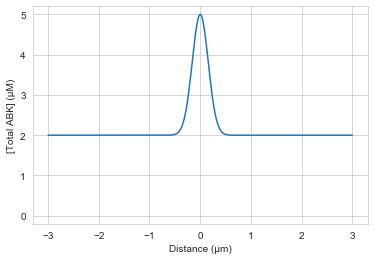

In [9]:
"""
Figure 16A
constructs total kinase profile with:
- constant concentration along chromosome arms
- Gaussian-like spike at the centrosome
    - represents effect of localization
"""

L = 6
N = 480
x = np.linspace(-L/2,L/2,N)

Atot_b = 2
Atot_h1 = 1.5
Atot_h2 = 0
Atot_w = 10
Atot_os = .4

Adip_r = Atot_b*Atot_h2 * np.exp(-Atot_b*Atot_w * (x - Atot_os)**2)
Adip_l = Atot_b*Atot_h2 * np.exp(-Atot_b*Atot_w * (x + Atot_os)**2)
Atot = Atot_b*Atot_h1 * np.exp(- Atot_b*Atot_w * x**2) + Atot_b - Adip_r - Adip_l

plt.plot(x,Atot)
plt.ylim(-.2,5.2)
plt.ylabel('[Total ABK] (\u03BCM)')
plt.xlabel('Distance (\u03BCm)');

In [10]:
"""
simulates reaction/diffusion in the phenomenological model 
using a spatially heterogeneous total kinase distribution
"""
start = time.time()
## algorithm takes <1 min

t_end = 180
dt = 0.001
t_save = .1

P = .65
D = 0.001

(A_arr,t_vec),A = spatial_simulation_nonbind_pheno(Atot,lo_ss,t_end,dt,t_save,L,N)

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 0.4 min


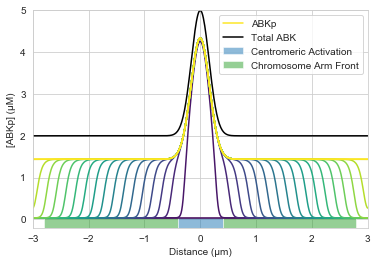

In [11]:
"""
Figure 16C
plots results of above simulation as the temporal evolution of spatial profiles
- reproduces centrosomal autoactivation + traveling fronts along the arms
"""

colors = sns.color_palette('viridis', n_colors=len(t_vec))
for i in range(0,len(t_vec),100): ## plots spatial profile every 10 sec
    plt.plot(x,A_arr[:,i], color=colors[i])

# sends last spatial profile to legend
plt.plot(x, A_arr[:,-1], color=colors[-1], label='ABKp')
# plots total kinase profile
plt.plot(x, Atot, 'k', label='Total ABK')
# produces color bars below plot to highlight different regions of traveling wave behavior
plt.axvspan(-2.8,-.4,ymax=.05,facecolor='C2', alpha=0.5)
plt.axvspan(-.4,.4,ymax=.05,facecolor='C0', alpha=0.5, label='Centromeric Activation')
plt.axvspan(2.8,.4,ymax=.05,facecolor='C2', alpha=0.5, label='Chromosome Arm Front')
plt.legend()

plt.ylabel('[ABKp] (\u03BCM)')
plt.xlabel('Distance (\u03BCm)')
plt.locator_params(axis='y', nbins=6)
plt.ylim(-.2,5)
plt.xlim(-3,3);

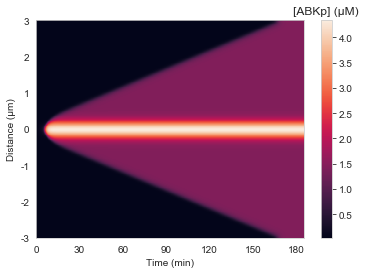

In [12]:
"""
Figure 16E
plots spatiotemporal heatmap of the above simulation
"""
heatmap = plt.pcolormesh(A_arr)
cbar = plt.colorbar(heatmap)
cbar.ax.set_title('[ABKp] (\u03BCM)')
plt.yticks(np.linspace(0,480,7), np.arange(-3, 4, 1))
plt.xticks(np.linspace(0,1750,7), np.arange(0,181,30))
plt.ylabel('Distance (\u03BCm)')
plt.xlabel('Time (min)');

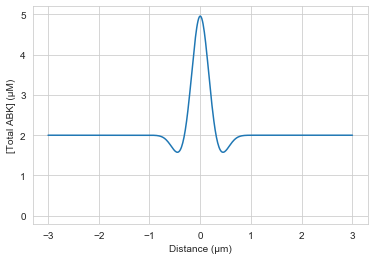

In [13]:
"""
Figure 16B
constructs total kinase profile with added valleys in between the arms + centrosome
- to simulate lower diffusion speed, where:
    - centrosomal-proximal kinase localizes toward the centrosome
    - outer arm kinase slowly reacts to equalize
"""
Atot_h2 = .25

Adip_r = Atot_b*Atot_h2 * np.exp(-Atot_b*Atot_w * (x - Atot_os)**2)
Adip_l = Atot_b*Atot_h2 * np.exp(-Atot_b*Atot_w * (x + Atot_os)**2)
Atot = Atot_b*Atot_h1 * np.exp(- Atot_b*Atot_w * x**2) + Atot_b - Adip_r - Adip_l

plt.plot(x,Atot)
plt.ylim(-.2,5.2)
plt.ylabel('[Total ABK] (\u03BCM)')
plt.xlabel('Distance (\u03BCm)');

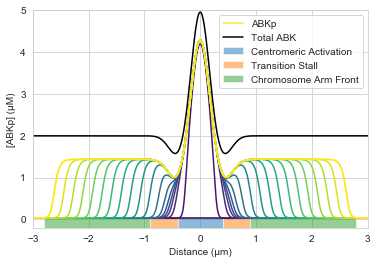

In [14]:
"""
Figure 16D
- kinase valleys produce a transition region stall between centromere/chromosome arms
- reflects stalling behavior in the mass-action model with D = 1E-05 um^2/s
"""

(A_arr,t_vec),A = spatial_simulation_nonbind_pheno(Atot,lo_ss,t_end,dt,t_save,L,N)

colors = sns.color_palette('viridis', n_colors=len(t_vec))
for i in range(0,len(t_vec),100): ## line every 10 sec
    plt.plot(x, A_arr[:,i], color=colors[i])

plt.plot(x,A_arr[:,-1], color=colors[-1], label='ABKp')
plt.plot(x,Atot, 'k', label='Total ABK')
plt.axvspan(-2.8,-.9, ymax=.05, facecolor='C2', alpha=0.5)
plt.axvspan(-.9,-.4, ymax=.05, facecolor='C1', alpha=0.5)
plt.axvspan(-.4,.4, ymax=.05, facecolor='C0', alpha=0.5, label='Centromeric Activation')
plt.axvspan(.9,.4, ymax=.05, facecolor='C1', alpha=0.5, label='Transition Stall')
plt.axvspan(2.8,.9, ymax=.05, facecolor='C2', alpha=0.5, label='Chromosome Arm Front')
plt.legend()

plt.ylabel('[ABKp] (\u03BCM)')
plt.xlabel('Distance (\u03BCm)')
plt.locator_params(axis='y', nbins=6)
plt.ylim(-.2,5)
plt.xlim(-3,3);

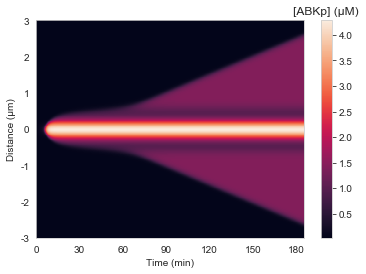

In [15]:
"""
Figure 16F
spatiotemporal heatmap showing stalling behavior
"""
heatmap = plt.pcolormesh(A_arr)
cbar = plt.colorbar(heatmap)
cbar.ax.set_title('[ABKp] (\u03BCM)')
plt.yticks(np.linspace(0,480,7), np.arange(-3, 4, 1))
plt.xticks(np.linspace(0,1750,7), np.arange(0,181,30))
plt.ylabel('Distance (\u03BCm)')
plt.xlabel('Time (min)');

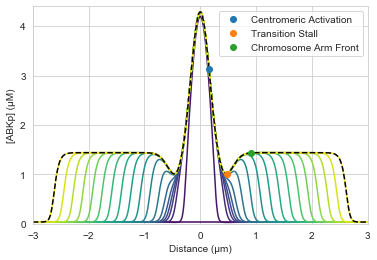

In [16]:
"""
Figure 17A
plots same data as Figure 16D, with discretized points representing the different behavior regions
"""

colors = sns.color_palette('viridis', n_colors=len(t_vec))
for i in range(0,len(t_vec),100): ## line every 10 sec
    plt.plot(x, A_arr[:,i], color=colors[i])

plt.plot(x, A_arr[:,-1], 'k--')

# three points chosen as representative for the different regions
x_slices = [252, 278, 312]
slice_colors = ['C0o','C1o','C2o']
labels = ['Centromeric Activation','Transition Stall','Chromosome Arm Front']
for x_slice,slice_color,label in zip(x_slices,slice_colors,labels):
    plt.plot(x[x_slice], A_arr[x_slice,int(t_end/t_save)], slice_color, label=label)

plt.legend()

plt.ylabel('[ABKp] (\u03BCM)')
plt.xlabel('Distance (\u03BCm)')
plt.locator_params(axis='y', nbins=6)
plt.ylim(0,4.4)
plt.xlim(-3,3);

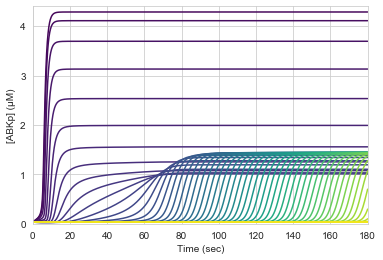

In [17]:
"""
Figure 17B
plots kinase activation as the spatial evolution of temporal profiles
- dark blue lines that activate first are the autoactivating centromeric x_slices 
- green/yellow lines are the outer centromere arm x_slices that activate with the traveling front
- while the transition region stall is shown here as the slow activation around 30-60 min
"""

# plot curve from every fourth spatial point from centromere to outer chromosome arm
x_slices_all = np.arange(240,480,4)
colors_all = sns.color_palette('viridis', n_colors=len(x_slices_all))

for c,i in enumerate(x_slices_all):
    plt.plot(t_vec[:],A_arr[i,:], color=colors_all[c])
    
plt.xlim(0,t_end)
plt.ylim(0,4.4)
plt.locator_params(axis='y', nbins=5)
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlabel('Time (sec)');

In [18]:
"""
algorithm to pull the times/active kinase values of each discretized x_slice (blue/orange/green pts)
at four intervals proportional to the respective low/high steady states
"""

t_of_xslices = []
Ap_of_xslices = []

for x_slice in x_slices:
    
    # lo/hi = initial/final values for each x_slice
    lo = A_arr[x_slice,0]
    hi = A_arr[x_slice,-1]
    
    # start time + active kinase lists with initial values
    t_of_xslice = [0]
    Ap_of_xslice = [lo]
    
    # 3 intermediate + 1 approximate final value
    intervals = [.2, .5, .8, .99]
    for interval in intervals:
        
        # calculate interval position, find nearest point, extract active kinase + time
        Ap, t = find_nearest( A_arr[x_slice,:], interval*(hi-lo)+lo )
        
        t_of_xslice.append(t)
        Ap_of_xslice.append(Ap)
        
    t_of_xslices.append(t_of_xslice)
    Ap_of_xslices.append(Ap_of_xslice)

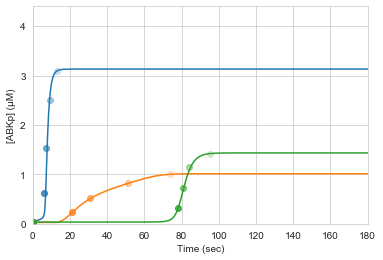

In [19]:
"""
Figure 17C
plots kinase activation with time of the three x_slices
plus points indicating 4 intervals in respect to low/high steady states
"""

t = np.arange(0,t_end+.1,t_save)
# plots active kinase curve with respect to time for each x_slice
for i in x_slices:
    plt.plot(t[:],A_arr[i,:])

# groups each x_slice with corresponding t/Ap vectors and colors
colors = ['C0o','C1o','C2o']
for x_slice,ts,Aps,color in zip(x_slices,t_of_xslices,Ap_of_xslices,colors):
    
    # plots each t/Ap with decreasing transparency
    alphas = [1,.8,.6,.4,.2]
    for t_,Ap_,alp in zip(ts,Aps,alphas):
        plt.plot(int(t_*t_save),Ap_,color,alpha=alp)

plt.xlim(0,t_end)
plt.ylim(0,4.4)
plt.locator_params(axis='y', nbins=5)
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlabel('Time (sec)');

In [20]:
"""
algorithm to build bistability curve at constant phosphatase + varying total kinase
"""
start = time.time()
## algorithm takes <1 min

tspan = np.linspace(0,10*60,1000)
Atot_range = np.arange(0,5,.01)
P = 0.65

lo_list = []
hi_list = []
Atot_bistable_list = []
bistable_list = []

for Atot in Atot_range:

    y = odeint(R_pheno,0,tspan)
    lo_ss = y[-1][0]
    lo_list.append(lo_ss)

    y = odeint(R_pheno,Atot,tspan)
    hi_ss = y[-1][0]
    hi_list.append(hi_ss)

    if not np.isclose(lo_ss, hi_ss, atol=.1):
        Atot_bistable_list.append(Atot)
        bistable_list.append((Atot, lo_ss, hi_ss))

unstablemanifold_list = []
for Atot, lo_ss, hi_ss in bistable_list:
    A0 = lo_ss
    A_sim = np.zeros(1)
    A_sim[-1] = -1
    while A_sim[-1] < A0:
        A0 += .01
        A_sim = odeint(R_pheno,A0,tspan)
    unstablemanifold_list.append(A0)

n_lo = saddle_node_locator(lo_list)
n_hi = saddle_node_locator(hi_list)

saddle_x = [Atot_range[n_hi]] + Atot_bistable_list + [Atot_range[n_lo-1]]
saddle_y = [hi_list[n_hi]] + unstablemanifold_list + [lo_list[n_lo-1]]

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 0.4 min


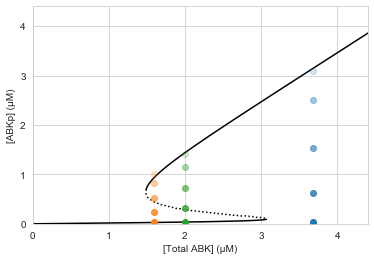

In [21]:
"""
Figure 17D
plots the interval points of the three x_slices along the bistability curve
- autoactivation in the centrosome occurs under the monostable high branch
- the traveling fronts along the arms occur within the bistable region
- the transition stall is towards the left of the bistable region where the threshold is highest, 
thus activation requires a greater flow of active kinase than the arms, slowing front travel
"""

# plots lower + upper stable branches + unstable manifold of bistability curve
plt.plot(Atot_range[:n_lo], lo_list[:n_lo], 'k')
plt.plot(Atot_range[n_hi:], hi_list[n_hi:], 'k')
plt.plot(saddle_x,saddle_y, 'k:')

# recalls Atot curve
Atot = Atot_b*Atot_h1 * np.exp(- Atot_b*Atot_w * x**2) + Atot_b - Adip_r - Adip_l

# plots each interval of each x_slice on the phase plane
for x_slice,ts,Aps,color in zip(x_slices,t_of_xslices,Ap_of_xslices,colors):
    Atot_ = Atot[x_slice]
    for t_,Ap_,alp in zip(ts,Aps,alphas):
        plt.plot(Atot_,Ap_,color,alpha=alp)

plt.xlabel('[Total ABK] (\u03BCM)')
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlim(0,4.4)
plt.ylim(0,4.4)
plt.locator_params(nbins=5);

In [22]:
"""
Rerun simulations with 120 spatial discretization points (instead of 480) for simpler animations
"""

N = 120
x = np.linspace(-L/2,L/2,N)

Adip_r = Atot_b*Atot_h2 * np.exp(-Atot_b*Atot_w * (x - Atot_os)**2)
Adip_l = Atot_b*Atot_h2 * np.exp(-Atot_b*Atot_w * (x + Atot_os)**2)
Atot = Atot_b*Atot_h1 * np.exp(- Atot_b*Atot_w * x**2) + Atot_b - Adip_r - Adip_l

(A_arr,t_vec),A = spatial_simulation_nonbind_pheno(Atot,lo_ss,t_end,dt,t_save,L,N)

In [23]:
"""
Supplemental Movie 1 (a)
compiles animation for kinase activation as it relates to the bistability curve
uses the phenomenological model, plots every 10 time steps
"""

# set up plotting objects
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set(xlim=(-0.2, 5*1.04), ylim=(-0.2, 5*1.04))
ax.set_xlabel('[Total ABK] (\u03BCM)')
ax.set_ylabel('[ABKp] (\u03BCM)')

# plot static bistability curve, outside of the animation
ax.plot(Atot_range[:n_lo], lo_list[:n_lo], 'k')
ax.plot(Atot_range[n_hi:], hi_list[n_hi:], 'k')
ax.plot(saddle_x,saddle_y, 'k:')

# initializes line style for traveling front phase plane movie
line, = ax.plot([], [], '-C0o',markersize=4)  

# define animate function, to be used to plot successive slides in movie
def animate(i):
    # plots one symmeterical half of the traveling wave on the phase plane
    line.set_data(Atot[60:],A_arr[60:,::10][:,i])
    return line,

# suppress plot display
plt.close()

# allows animation to be played inline (only needs to be run once per notebook)
plt.rcParams["animation.html"] = "jshtml"

# compile lines from animate() into movie
animation.FuncAnimation(fig, animate, frames=180, interval=20, blit=True)

In [24]:
"""
Supplemental Movie 1 (b)
compiles animation for kinase activation in space
uses the phenomenological model, plots every 10 time steps
"""

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set(xlim=(-3.2,3.2), ylim=(-0.2, 5*1.04))

ax.set_ylabel('[ABKp] (\u03BCM)')
ax.set_xlabel('Distance (\u03BCm)')

line, = ax.plot([], [], '-C0o',markersize=4)  

def animate(i):
    line.set_data(x,A_arr[:,::10][:,i])
    return line,

plt.close()
animation.FuncAnimation(fig, animate, frames=180, interval=20, blit=True)